In [33]:
import os 
os.chdir("/data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/")
print("Your working directory is", os.getcwd())

Your working directory is /data/outputs/cellranger_outputs/Analysis_by_Mo_Multi


In [34]:
import shutil
total, used, free = shutil.disk_usage("/")
print(f"Total: {total // (1024**3)} GB")
print(f"Used: {used // (1024**3)} GB") 
print(f"Free: {free // (1024**3)} GB")

Total: 937 GB
Used: 817 GB
Free: 72 GB


In [3]:
import gdown

url = 'https://drive.google.com/drive/folders/1vf1ijfQSk7rGdDGpBntR5bi5g6gNt-Gx'
gdown.download_folder(url, quiet=False, use_cookies=False)


Retrieving folder contents


Processing file 1wGHcEEyagcrEMTm9j3GTgcY02QgbU_ls args.json
Processing file 1ohlnSNk3hBiMU25x0-zamOOA2RQ-lzPG best_model.pt
Processing file 1_JjujKwHC-yjf5A25_RLKJGIFjb__zLr vocab.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1wGHcEEyagcrEMTm9j3GTgcY02QgbU_ls
To: /data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain/args.json
100%|██████████| 1.04k/1.04k [00:00<00:00, 2.77MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ohlnSNk3hBiMU25x0-zamOOA2RQ-lzPG
From (redirected): https://drive.google.com/uc?id=1ohlnSNk3hBiMU25x0-zamOOA2RQ-lzPG&confirm=t&uuid=558ac166-aaf6-4706-a3ba-a14343c529f9
To: /data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain/best_model.pt
100%|██████████| 205M/205M [00:03<00:00, 63.3MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1_JjujKwHC-yjf5A25_RLKJGIFjb__zLr
To: /data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain/vocab.json
100%|██████████| 1.32M/1.32M [00:00<00:00, 26.6MB/s]
Download completed


['/data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain/args.json',
 '/data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain/best_model.pt',
 '/data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain/vocab.json']

In [32]:
"""
Complete solution to bypass torchtext issues in scGPT
This patches the torchtext imports before scGPT loads
"""

import sys
from collections import Counter
from typing import List, Dict, Union, Optional, Any
import json

# =============== STEP 1: Create our Vocab replacement ===============
class Vocab:
    """Complete drop-in replacement for torchtext.vocab.Vocab"""
    
    def __init__(self, 
                 counter: Counter = None,
                 min_freq: int = 1,
                 specials: Optional[List[str]] = None,
                 special_first: bool = True,
                 vectors=None,
                 unk_token="<unk>",
                 **kwargs):
        if specials is None:
            specials = []
        
        self.min_freq = min_freq
        self.specials = specials
        self.special_first = special_first
        self.unk_token = unk_token
        
        self.itos = []  # index to string
        self.stoi = {}  # string to index
        self.freqs = Counter()
        
        # Add special tokens first if specified
        if special_first:
            for special in specials:
                if special not in self.stoi:
                    self.itos.append(special)
                    self.stoi[special] = len(self.stoi)
        
        # Build from counter
        if counter is not None:
            self._build_vocab_from_counter(counter)
        
        # Add special tokens last if not first
        if not special_first:
            for special in specials:
                if special not in self.stoi:
                    self.itos.append(special)
                    self.stoi[special] = len(self.stoi)
    
    def _build_vocab_from_counter(self, counter: Counter):
        """Build vocabulary from counter"""
        self.freqs = counter
        sorted_items = counter.most_common()
        
        for token, freq in sorted_items:
            if freq >= self.min_freq and token not in self.stoi:
                self.itos.append(token)
                self.stoi[token] = len(self.stoi)
    
    def __len__(self) -> int:
        return len(self.itos)
    
    def __getitem__(self, token: str) -> int:
        if isinstance(token, str):
            return self.stoi.get(token, self.stoi.get(self.unk_token, 0))
        elif isinstance(token, list):
            return [self[t] for t in token]
        else:
            return self.stoi.get(str(token), self.stoi.get(self.unk_token, 0))
    
    def __contains__(self, token: str) -> bool:
        return token in self.stoi
    
    def lookup_token(self, index: int) -> str:
        if 0 <= index < len(self.itos):
            return self.itos[index]
        else:
            return self.unk_token
    
    def lookup_tokens(self, indices: List[int]) -> List[str]:
        return [self.lookup_token(idx) for idx in indices]
    
    def lookup_indices(self, tokens: List[str]) -> List[int]:
        return [self[token] for token in tokens]
    
    def get_itos(self) -> List[str]:
        return self.itos.copy()
    
    def get_stoi(self) -> Dict[str, int]:
        return self.stoi.copy()
    
    def append_token(self, token: str):
        if token not in self.stoi:
            self.stoi[token] = len(self.itos)
            self.itos.append(token)
    
    def insert_token(self, token: str, index: int):
        if token in self.stoi:
            return
        self.itos.insert(index, token)
        self.stoi = {t: i for i, t in enumerate(self.itos)}
    
    def extend(self, tokens: List[str]):
        for token in tokens:
            self.append_token(token)
    
    def set_vectors(self, *args, **kwargs):
        """Compatibility method"""
        pass
    
    @property
    def vectors(self):
        return None

# VocabPybind is the same as Vocab
VocabPybind = Vocab

# =============== STEP 2: Create mock torchtext modules ===============
class MockTorchTextVocab:
    """Mock torchtext.vocab module"""
    Vocab = Vocab
    
    @staticmethod
    def build_vocab_from_iterator(iterator, **kwargs):
        counter = Counter()
        for tokens in iterator:
            if isinstance(tokens, str):
                tokens = tokens.split()
            counter.update(tokens)
        return Vocab(counter=counter, **kwargs)

class MockTorchTextTorchText:
    """Mock torchtext._torchtext module"""
    Vocab = VocabPybind

class MockTorchText:
    """Mock torchtext module"""
    vocab = MockTorchTextVocab()
    _torchtext = MockTorchTextTorchText()

# =============== STEP 3: Monkey patch sys.modules BEFORE importing scgpt ===============
# This is crucial - we need to patch before scgpt tries to import torchtext
sys.modules['torchtext'] = MockTorchText()
sys.modules['torchtext.vocab'] = MockTorchTextVocab()
sys.modules['torchtext._torchtext'] = MockTorchTextTorchText()

# Also patch the individual classes that might be imported directly
sys.modules['torchtext'].vocab.Vocab = Vocab
sys.modules['torchtext']._torchtext.Vocab = VocabPybind

print("✅ TorchText monkey patch applied successfully!")

# =============== STEP 4: Enhanced GeneVocab for scGPT compatibility ===============
class GeneVocab(Vocab):
    """
    Enhanced vocabulary class for genes, fully compatible with scGPT
    """
    
    @classmethod
    def from_file(cls, vocab_file: str):
        """Load vocabulary from JSON file (scGPT format)"""
        with open(vocab_file, 'r') as f:
            vocab_data = json.load(f)
        
        vocab = cls()
        
        if isinstance(vocab_data, dict):
            # If it's a stoi mapping
            vocab.stoi = vocab_data
            vocab.itos = [''] * len(vocab_data)
            for token, idx in vocab_data.items():
                if 0 <= idx < len(vocab.itos):
                    vocab.itos[idx] = token
        elif isinstance(vocab_data, list):
            # If it's an itos list
            vocab.itos = vocab_data
            vocab.stoi = {token: idx for idx, token in enumerate(vocab_data)}
        else:
            raise ValueError("Unsupported vocabulary file format")
        
        return vocab
    
    def save_json(self, vocab_file: str):
        """Save vocabulary to JSON file"""
        with open(vocab_file, 'w') as f:
            json.dump(self.stoi, f, indent=2)

# =============== STEP 5: Now we can safely import scgpt ===============
try:
    # Import the standard libraries first
    import copy
    import os
    from pathlib import Path
    import warnings
    import torch
    from anndata import AnnData
    import scanpy as sc
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import networkx as nx
    import pandas as pd
    import tqdm
    import gseapy as gp
    
    # Add scGPT to path if needed
    sys.path.insert(0, "../")
    
    # NOW import scgpt - it should work with our patched torchtext
    import scgpt as scg
    from scgpt.tasks import GeneEmbedding
    from scgpt.tokenizer.gene_tokenizer import GeneVocab as SCGPTGeneVocab
    from scgpt.model import TransformerModel
    from scgpt.preprocess import Preprocessor
    from scgpt.utils import set_seed
    
    print("✅ scGPT imported successfully!")
    print("✅ All dependencies loaded without torchtext conflicts!")
    
    # Set up environment
    os.environ["KMP_WARNINGS"] = "off"
    warnings.filterwarnings('ignore')
    
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Make sure scGPT is installed: pip install git+https://github.com/bowang-lab/scGPT.git")
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    print("Try restarting your kernel and running this code again.")

print("\n🎉 Setup complete! You can now run the scGPT GRN tutorial.")

✅ TorchText monkey patch applied successfully!
✅ scGPT imported successfully!
✅ All dependencies loaded without torchtext conflicts!

🎉 Setup complete! You can now run the scGPT GRN tutorial.


In [35]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins




In [36]:
sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed

# Step 1: Load pre-trained model and your microglia dataset

# 1.1 Load pre-trained scGPT model
# Make sure to update these paths to your actual model location
model_dir = Path("/data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"
# Load vocabulary
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Load model configuration
with open(model_config_file, "r") as f:
    model_configs = json.load(f)

print(f"Resume model from {model_file}, the model args will override the config {model_config_file}.")

embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

AttributeError: 'MockTorchTextVocab' object has no attribute 'vocab'

In [11]:
import torch

# Define device
device = torch.device("cpu")

ntokens = len(vocab)

model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    # Load full state dict
    model.load_state_dict(torch.load(model_file, map_location=device))
    print(f"Loading all model params from {model_file}")
except RuntimeError as e:
    print("Full load failed, trying partial load:", e)

    # Load only matching parameters
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file, map_location=device)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

# Move model to device
model.to(device)


Full load failed, trying partial load: Error(s) in loading state_dict for TransformerModel:
	Missing key(s) in state_dict: "transformer_encoder.layers.0.self_attn.in_proj_weight", "transformer_encoder.layers.0.self_attn.in_proj_bias", "transformer_encoder.layers.1.self_attn.in_proj_weight", "transformer_encoder.layers.1.self_attn.in_proj_bias", "transformer_encoder.layers.2.self_attn.in_proj_weight", "transformer_encoder.layers.2.self_attn.in_proj_bias", "transformer_encoder.layers.3.self_attn.in_proj_weight", "transformer_encoder.layers.3.self_attn.in_proj_bias", "transformer_encoder.layers.4.self_attn.in_proj_weight", "transformer_encoder.layers.4.self_attn.in_proj_bias", "transformer_encoder.layers.5.self_attn.in_proj_weight", "transformer_encoder.layers.5.self_attn.in_proj_bias", "transformer_encoder.layers.6.self_attn.in_proj_weight", "transformer_encoder.layers.6.self_attn.in_proj_bias", "transformer_encoder.layers.7.self_attn.in_proj_weight", "transformer_encoder.layers.7.self_a

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [37]:
# 1.2 Load and preprocess your microglia dataset
# Replace with your actual data path
adata = sc.read("/data/F1andF2_DANIDN_fully_processed_integrated.h5ad")

In [38]:
# Set preprocessing parameters based on your data
data_is_raw = False  # Set to True if your data is raw counts


In [39]:
# Preprocess the data following scGPT pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)


In [40]:
adata

AnnData object with n_obs × n_vars = 149834 × 18949
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'scDblFinder_class', 'nCount_SCT', 'nFeature_SCT', 'test_res.0.3', 'seurat_clusters', 'test_res.0.1', 'test_res.0.2', 'BroadCellType', 'Mutation', 'Batch', 'Clone', 'ident', 'batch', 'SampleID', 'WholeID', 'PPMI_ID', 'RECRUITMENT_CAT', 'IMAGING_CAT', 'ENROLL_CAT', 'DESCRP_CAT', 'genetic_sex', 'pheno', 'Barcode_DZNE', 'Alternate.MRN', 'IID', 'mutation', 'ethnicity', 'BATCH', 'Barcode_last4', 'integrated_snn_res.0.1', 'integrated_snn_res.0.5', 'CellType', 'monocle3_clusters', 'monocle3_partitions', 'Size_factor', 'monocle3_pseudotime', 'integrated_snn_res.0.2', 'mutationV2', 'cell_id', 'n_genes', 'leiden_harmony', 'BroadCellType_harmonized', 'developmental_pseudotime', 'Genotype', 'batch_harmonized', 'unified_sample_id', 'IntegratedID'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable

In [41]:
preprocessor(adata, batch_key="IntegratedID")


scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


In [46]:
# Flexible model loading - update the path to where you downloaded the model

import json
from pathlib import Path
import torch
import os

# Set random seed
set_seed(42)

# Define constants
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

# ===== UPDATE THIS PATH TO YOUR MODEL LOCATION =====
# Your model is located here:
possible_paths = [
    Path("/data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain"),
    Path("../save/scGPT_bc"),           # Original tutorial path (backup)
    Path("./save/scGPT_bc"),            # Current directory (backup)
]

# Your exact path:
your_model_path = Path("/data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain")

model_dir = None
for path in possible_paths:
    expanded_path = Path(path).expanduser()  # Handle ~ in paths
    if expanded_path.exists():
        model_dir = expanded_path
        break

if model_dir is None:
    print("❌ Model directory not found in any of these locations:")
    for path in possible_paths:
        print(f"   - {Path(path).expanduser()}")
    print("\n📋 To fix this:")
    print("1. Download the scGPT blood model from:")
    print("   https://drive.google.com/drive/folders/1kkug5C7NjvXIwQGGaGoqXTk_Lb_pDrBU")
    print("2. Extract/place it in one of the above locations, OR")
    print("3. Update the 'possible_paths' list above with your actual path")
    
    # Let user specify path interactively
    print("\n💡 Or specify the path now:")
    user_path = input("Enter the full path to your scGPT_bc directory (or press Enter to skip): ").strip()
    if user_path:
        model_dir = Path(user_path)
        if not model_dir.exists():
            raise FileNotFoundError(f"Specified path does not exist: {model_dir}")
    else:
        raise FileNotFoundError("No valid model directory found")

print(f"✅ Using model directory: {model_dir}")

# Define file paths
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

# Check if all required files exist
required_files = [model_config_file, model_file, vocab_file]
missing_files = [f for f in required_files if not f.exists()]

if missing_files:
    print(f"❌ Missing files in {model_dir}:")
    for f in missing_files:
        print(f"   - {f.name}")
    print("\n📋 The directory should contain:")
    print("   - best_model.pt (model weights)")
    print("   - args.json (model configuration)")
    print("   - vocab.json (vocabulary)")
    raise FileNotFoundError(f"Missing required files: {[f.name for f in missing_files]}")

# Load vocabulary
print("Loading vocabulary...")
try:
    # Load the JSON file directly
    import json
    with open(vocab_file, 'r') as f:
        vocab_data = json.load(f)
    
    # Create a simple vocab object that mimics scGPT's GeneVocab interface
    class SimpleGeneVocab:
        def __init__(self):
            self.itos = []
            self.stoi = {}
        
        def __len__(self):
            return len(self.itos)
        
        def __contains__(self, token):
            return token in self.stoi
        
        def __getitem__(self, token):
            return self.stoi.get(token, self.stoi.get('<unk>', 0))
        
        def get_stoi(self):
            return self.stoi.copy()
        
        def get_itos(self):
            return self.itos.copy()
        
        def append_token(self, token):
            if token not in self.stoi:
                self.stoi[token] = len(self.itos)
                self.itos.append(token)
    
    vocab = SimpleGeneVocab()
    
    if isinstance(vocab_data, dict):
        # If it's a stoi mapping
        vocab.stoi = vocab_data
        vocab.itos = [''] * len(vocab_data)
        for token, idx in vocab_data.items():
            if 0 <= idx < len(vocab.itos):
                vocab.itos[idx] = token
    elif isinstance(vocab_data, list):
        # If it's an itos list
        vocab.itos = vocab_data
        vocab.stoi = {token: idx for idx, token in enumerate(vocab_data)}
    
    print(f"✅ Loaded vocabulary directly from JSON: {len(vocab)} tokens")
    
except Exception as e:
    print(f"❌ Could not load vocabulary: {e}")
    # Create a minimal vocab as fallback
    class SimpleGeneVocab:
        def __init__(self):
            self.itos = []
            self.stoi = {}
        
        def __len__(self):
            return len(self.itos)
        
        def __contains__(self, token):
            return token in self.stoi
        
        def __getitem__(self, token):
            return self.stoi.get(token, self.stoi.get('<unk>', 0))
        
        def get_stoi(self):
            return self.stoi.copy()
        
        def append_token(self, token):
            if token not in self.stoi:
                self.stoi[token] = len(self.itos)
                self.itos.append(token)
    
    vocab = SimpleGeneVocab()
    for token in special_tokens:
        vocab.append_token(token)
    print(f"⚠️  Created minimal vocabulary with {len(vocab)} tokens")

# Add special tokens to vocabulary
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Create gene2idx mapping
gene2idx = vocab.get_stoi()
print(f"✅ Vocabulary loaded: {len(vocab)} tokens")

# Load model configuration
print("Loading model configuration...")
with open(model_config_file, "r") as f:
    model_configs = json.load(f)

# Extract model parameters
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]  
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model
print("Creating model...")
ntokens = len(vocab)
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

# Load model weights
print("Loading model weights...")
try:
    model.load_state_dict(torch.load(model_file, map_location=device))
    print(f"✅ Loaded all model params from {model_file}")
except Exception as e:
    print(f"Partial loading due to: {e}")
    # Load only matching parameters
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file, map_location=device)
    pretrained_dict = {
        k: v for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(pretrained_dict)} matching parameters")

model.to(device)
model.eval()

print("✅ Model setup complete!")
print(f"✅ gene2idx defined with {len(gene2idx)} genes")
print("🚀 Ready for Step 2: Gene embeddings extraction")

✅ Using model directory: /data/outputs/cellranger_outputs/Analysis_by_Mo_Multi/scGPT_brain
Loading vocabulary...
✅ Loaded vocabulary directly from JSON: 60697 tokens
✅ Vocabulary loaded: 60697 tokens
Loading model configuration...
Using device: cpu
Creating model...
Loading model weights...
Partial loading due to: Error(s) in loading state_dict for TransformerModel:
	Missing key(s) in state_dict: "transformer_encoder.layers.0.self_attn.in_proj_weight", "transformer_encoder.layers.0.self_attn.in_proj_bias", "transformer_encoder.layers.1.self_attn.in_proj_weight", "transformer_encoder.layers.1.self_attn.in_proj_bias", "transformer_encoder.layers.2.self_attn.in_proj_weight", "transformer_encoder.layers.2.self_attn.in_proj_bias", "transformer_encoder.layers.3.self_attn.in_proj_weight", "transformer_encoder.layers.3.self_attn.in_proj_bias", "transformer_encoder.layers.4.self_attn.in_proj_weight", "transformer_encoder.layers.4.self_attn.in_proj_bias", "transformer_encoder.layers.5.self_attn.

In [84]:
adata

AnnData object with n_obs × n_vars = 149834 × 1200
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'scDblFinder_class', 'nCount_SCT', 'nFeature_SCT', 'test_res.0.3', 'seurat_clusters', 'test_res.0.1', 'test_res.0.2', 'BroadCellType', 'Mutation', 'Batch', 'Clone', 'ident', 'batch', 'SampleID', 'WholeID', 'PPMI_ID', 'RECRUITMENT_CAT', 'IMAGING_CAT', 'ENROLL_CAT', 'DESCRP_CAT', 'genetic_sex', 'pheno', 'Barcode_DZNE', 'Alternate.MRN', 'IID', 'mutation', 'ethnicity', 'BATCH', 'Barcode_last4', 'integrated_snn_res.0.1', 'integrated_snn_res.0.5', 'CellType', 'monocle3_clusters', 'monocle3_partitions', 'Size_factor', 'monocle3_pseudotime', 'integrated_snn_res.0.2', 'mutationV2', 'cell_id', 'n_genes', 'leiden_harmony', 'BroadCellType_harmonized', 'developmental_pseudotime', 'Genotype', 'batch_harmonized', 'unified_sample_id', 'IntegratedID', '32_SCORE', '91_SCORE', '19_SCORE', '80_SCORE', '103_SCORE', '5_SCORE', '96_SCORE', '11_SCORE', '14_SCORE', '4_SCORE', '6_SCORE

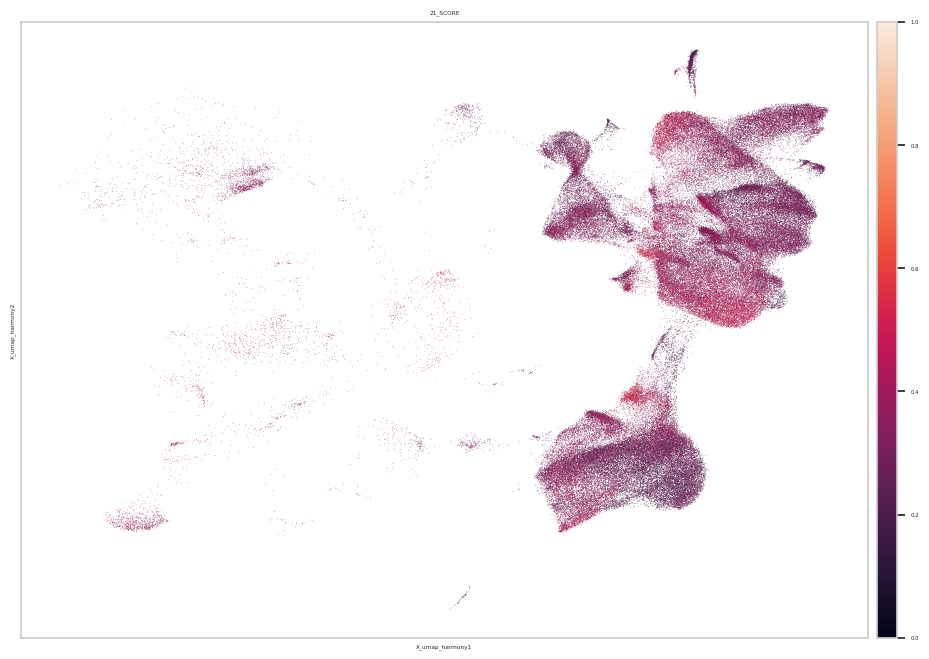

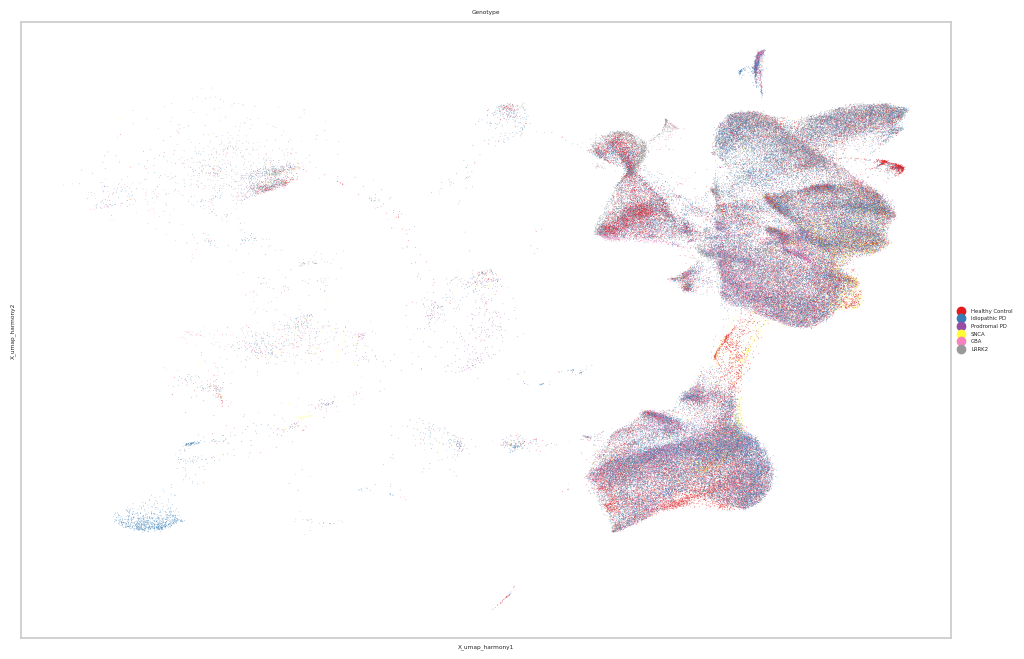

In [90]:
sc.pl.embedding(adata, basis="X_umap_harmony", color="21_SCORE")
sc.pl.embedding(adata, basis="X_umap_harmony", color="Genotype")


In [47]:
# Step 2: Retrieve scGPT's gene embeddings
print("Retrieving gene embeddings...")
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

# Filter on intersection between your HVGs and scGPT's vocabulary
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))


Retrieving gene embeddings...
Retrieved gene embeddings for 1191 genes.


In [48]:
# Step 3: Extract gene programs from gene embedding network
print("Constructing gene embedding network...")
embed = GeneEmbedding(gene_embeddings)


Constructing gene embedding network...


100%|██████████| 1191/1191 [00:00<00:00, 2445137.57it/s]


In [49]:
# Perform Louvain clustering with desired resolution
print("Performing Louvain clustering...")
resolution = 10  # You can adjust this parameter
gdata = embed.get_adata(resolution=resolution)
metagenes = embed.get_metagenes(gdata)

Performing Louvain clustering...


In [50]:
# Filter clusters with 5 or more genes
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes


In [51]:
adata

AnnData object with n_obs × n_vars = 149834 × 1200
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'scDblFinder_class', 'nCount_SCT', 'nFeature_SCT', 'test_res.0.3', 'seurat_clusters', 'test_res.0.1', 'test_res.0.2', 'BroadCellType', 'Mutation', 'Batch', 'Clone', 'ident', 'batch', 'SampleID', 'WholeID', 'PPMI_ID', 'RECRUITMENT_CAT', 'IMAGING_CAT', 'ENROLL_CAT', 'DESCRP_CAT', 'genetic_sex', 'pheno', 'Barcode_DZNE', 'Alternate.MRN', 'IID', 'mutation', 'ethnicity', 'BATCH', 'Barcode_last4', 'integrated_snn_res.0.1', 'integrated_snn_res.0.5', 'CellType', 'monocle3_clusters', 'monocle3_partitions', 'Size_factor', 'monocle3_pseudotime', 'integrated_snn_res.0.2', 'mutationV2', 'cell_id', 'n_genes', 'leiden_harmony', 'BroadCellType_harmonized', 'developmental_pseudotime', 'Genotype', 'batch_harmonized', 'unified_sample_id', 'IntegratedID'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_

In [54]:
# Step 4: Visualize gene program activation on your microglia dataset
import matplotlib.pyplot as plt
import seaborn as sns

def plot_microglia_gene_programs(adata, embed, mgs, output_pdf="gene_programs.pdf"):
    """
    Plot gene program scores for microglia types and save as high-quality PDF.
    """
    sns.set(font_scale=0.35)
    
    # Score metagenes for your data
    embed.score_metagenes(adata, mgs)
    
    # Plot using "microglia_type" instead of "celltype"
    embed.plot_metagenes_scores(adata, mgs, "Genotype")
    
    plt.tight_layout()
    
    # Save as high-quality PDF
    plt.savefig(output_pdf, format='pdf', dpi=600, bbox_inches='tight')  # dpi=600 ensures high quality
    plt.show()



<Figure size 500x1300 with 0 Axes>

<Figure size 640x480 with 0 Axes>

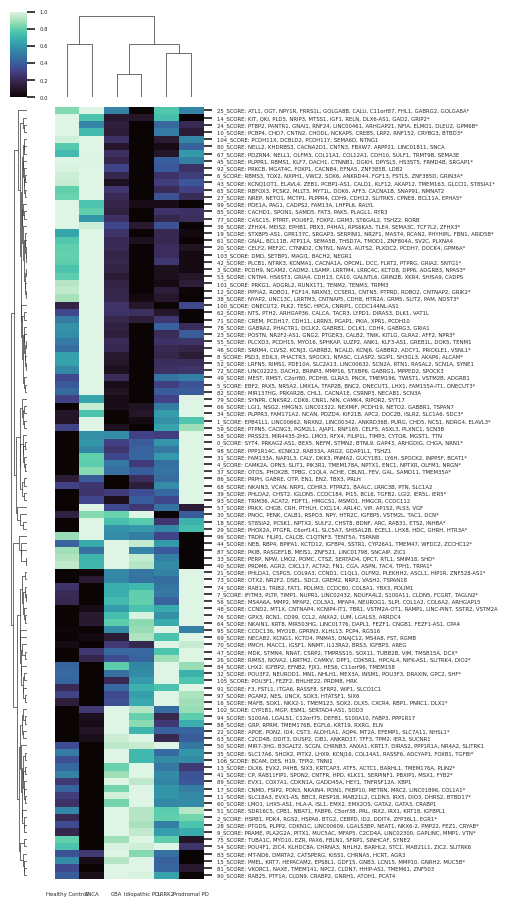

In [55]:
plot_microglia_gene_programs(adata, embed, mgs)


In [63]:
adata

AnnData object with n_obs × n_vars = 149834 × 1200
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'scDblFinder_class', 'nCount_SCT', 'nFeature_SCT', 'test_res.0.3', 'seurat_clusters', 'test_res.0.1', 'test_res.0.2', 'BroadCellType', 'Mutation', 'Batch', 'Clone', 'ident', 'batch', 'SampleID', 'WholeID', 'PPMI_ID', 'RECRUITMENT_CAT', 'IMAGING_CAT', 'ENROLL_CAT', 'DESCRP_CAT', 'genetic_sex', 'pheno', 'Barcode_DZNE', 'Alternate.MRN', 'IID', 'mutation', 'ethnicity', 'BATCH', 'Barcode_last4', 'integrated_snn_res.0.1', 'integrated_snn_res.0.5', 'CellType', 'monocle3_clusters', 'monocle3_partitions', 'Size_factor', 'monocle3_pseudotime', 'integrated_snn_res.0.2', 'mutationV2', 'cell_id', 'n_genes', 'leiden_harmony', 'BroadCellType_harmonized', 'developmental_pseudotime', 'Genotype', 'batch_harmonized', 'unified_sample_id', 'IntegratedID', '32_SCORE', '91_SCORE', '19_SCORE', '80_SCORE', '103_SCORE', '5_SCORE', '96_SCORE', '11_SCORE', '14_SCORE', '4_SCORE', '6_SCORE

In [76]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

# Set global plotting style
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")


# -------------------- Data Preparation -------------------- #
def prepare_data_for_auc(adata, target_genes, condition_key='Genotype', cell_type_key=None, cell_type_filter=None):
    """
    Prepare data for AUC analysis by extracting expression values and binary labels.
    
    Parameters:
    - adata: AnnData object
    - target_genes: list of genes to analyze
    - condition_key: column in adata.obs representing the condition
    - cell_type_key: column in adata.obs for optional cell type filtering
    - cell_type_filter: regex pattern to filter cells by type
    
    Returns:
    - expr_df: pandas DataFrame with gene expression + labels
    - available_genes: list of genes found in adata
    """
    adata_subset = adata.copy()
    
    # Filter by cell type if requested
    if cell_type_key and cell_type_key in adata.obs.columns and cell_type_filter:
        mask = adata.obs[cell_type_key].str.contains(cell_type_filter, case=False, na=False)
        adata_subset = adata[mask].copy()
        print(f"Filtered to {adata_subset.n_obs} cells matching '{cell_type_filter}'")
    
    # Check available genes
    available_genes = [g for g in target_genes if g in adata_subset.var_names]
    missing_genes = [g for g in target_genes if g not in adata_subset.var_names]
    
    if missing_genes:
        print(f"Warning: Missing genes: {missing_genes}")
    if not available_genes:
        raise ValueError("No target genes found in the dataset!")
    
    # Extract expression
    gene_expr = adata_subset[:, available_genes].X
    if hasattr(gene_expr, 'toarray'):
        gene_expr = gene_expr.toarray()
    
    expr_df = pd.DataFrame(gene_expr, columns=available_genes)
    expr_df['Condition'] = adata_subset.obs[condition_key].values
    expr_df['Cell'] = adata_subset.obs.index
    
    return expr_df, available_genes


# -------------------- Single Gene AUC -------------------- #
def calculate_single_gene_auc(expr_df, gene, control_label='Healthy Control'):
    """Compute AUC and ROC curve for a single gene."""
    y_true = (expr_df['Condition'] != control_label).astype(int)
    y_score = expr_df[gene].values
    try:
        auc_score = roc_auc_score(y_true, y_score)
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        return auc_score, fpr, tpr, thresholds
    except:
        return None, None, None, None


# -------------------- ROC Plots -------------------- #
def plot_individual_roc_curves(expr_df, genes, control_label='Healthy Control', n_cols=3, figsize=(15, 10)):
    n_genes = len(genes)
    n_rows = (n_genes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else axes.reshape(-1)
    
    colors = plt.cm.Set1(np.linspace(0, 1, n_genes))
    
    for i, gene in enumerate(genes):
        auc_score, fpr, tpr, _ = calculate_single_gene_auc(expr_df, gene, control_label)
        ax = axes[i]
        if auc_score is not None:
            ax.plot(fpr, tpr, color=colors[i], lw=2, label=f'{gene} (AUC={auc_score:.3f})')
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
            ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
            ax.set_title(f'ROC - {gene}')
            ax.legend()
        else:
            ax.text(0.5, 0.5, f'Cannot compute AUC for {gene}', ha='center', va='center')
    
    # Remove empty subplots
    for j in range(n_genes, n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    return fig


def plot_combined_roc_curve(expr_df, genes, control_label='Healthy Control', figsize=(10, 8)):
    plt.figure(figsize=figsize)
    colors = plt.cm.Set1(np.linspace(0, 1, len(genes)))
    auc_scores = {}
    
    for i, gene in enumerate(genes):
        auc_score, fpr, tpr, _ = calculate_single_gene_auc(expr_df, gene, control_label)
        if auc_score is not None:
            plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{gene} (AUC={auc_score:.3f})')
            auc_scores[gene] = auc_score
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Combined ROC Curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    return auc_scores


# -------------------- Gene Signature -------------------- #
def calculate_gene_signature_auc(expr_df, genes, control_label='Healthy Control', method='mean'):
    if method == 'mean':
        signature = expr_df[genes].mean(axis=1)
    elif method == 'sum':
        signature = expr_df[genes].sum(axis=1)
    elif method == 'weighted':
        weights = []
        for gene in genes:
            auc_score, _, _, _ = calculate_single_gene_auc(expr_df, gene, control_label)
            weights.append(auc_score if auc_score is not None else 0.5)
        weights = np.array(weights)
        signature = (expr_df[genes] * weights).sum(axis=1)
    
    y_true = (expr_df['Condition'] != control_label).astype(int)
    auc_score = roc_auc_score(y_true, signature)
    fpr, tpr, thresholds = roc_curve(y_true, signature)
    
    return auc_score, fpr, tpr, signature


def plot_signature_roc(expr_df, genes, control_label='Healthy Control', figsize=(12, 5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    methods = ['mean', 'sum', 'weighted']
    colors = ['blue', 'red', 'green']
    
    for method, color in zip(methods, colors):
        auc_score, fpr, tpr, _ = calculate_gene_signature_auc(expr_df, genes, control_label, method)
        ax1.plot(fpr, tpr, color=color, lw=2, label=f'{method.title()} (AUC={auc_score:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_xlabel('FPR'); ax1.set_ylabel('TPR')
    ax1.set_title('Gene Signature ROC')
    ax1.legend(); ax1.grid(alpha=0.3)
    
    # Distribution of best (weighted) signature
    best_auc, _, _, signature = calculate_gene_signature_auc(expr_df, genes, control_label, method='weighted')
    for cond in expr_df['Condition'].unique():
        mask = expr_df['Condition'] == cond
        ax2.hist(signature[mask], alpha=0.6, bins=30, label=cond)
    
    ax2.set_xlabel('Signature Score'); ax2.set_ylabel('Frequency')
    ax2.set_title(f'Signature Distribution (Weighted AUC={best_auc:.3f})')
    ax2.legend(); ax2.grid(alpha=0.3)
    
    plt.tight_layout(); plt.show()
    return fig


# -------------------- Cross-Validation -------------------- #
def cross_validation_analysis(expr_df, genes, control_label='Healthy Control', cv_folds=5):
    X = expr_df[genes].values
    y = (expr_df['Condition'] != control_label).astype(int)
    X_scaled = StandardScaler().fit_transform(X)
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for name, model in models.items():
        scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
        results[name] = {'mean_auc': scores.mean(), 'std_auc': scores.std(), 'cv_scores': scores}
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(results.keys(), [v['mean_auc'] for v in results.values()],
                   yerr=[v['std_auc'] for v in results.values()], capsize=10, alpha=0.7)
    
    for bar, name in zip(bars, results.keys()):
        mean, std = results[name]['mean_auc'], results[name]['std_auc']
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
                 f'{mean:.3f} ± {std:.3f}', ha='center', va='bottom')
    
    plt.ylabel('CV AUC Score'); plt.title(f'{cv_folds}-Fold Cross-Validation'); plt.ylim(0, 1)
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
    
    return results


# -------------------- Comprehensive Analysis -------------------- #
def comprehensive_auc_analysis(adata, target_genes, condition_key='Genotype',
                               control_label='Healthy Control', cell_type_key=None,
                               cell_type_filter='dopamin|DA'):
    print("="*60)
    print("COMPREHENSIVE AUC ANALYSIS")
    print("="*60)
    
    # Prepare data
    expr_df, available_genes = prepare_data_for_auc(
        adata, target_genes, condition_key, cell_type_key, cell_type_filter)
    
    print(f"Data shape: {expr_df.shape}")
    print(f"Conditions: {expr_df['Condition'].value_counts()}")
    
    # Individual gene AUC
    individual_auc_scores = {}
    for gene in available_genes:
        auc_score, _, _, _ = calculate_single_gene_auc(expr_df, gene, control_label)
        if auc_score: individual_auc_scores[gene] = auc_score
    
    # Sorted gene AUC
    sorted_genes = sorted(individual_auc_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nIndividual Gene AUC Scores:")
    for gene, score in sorted_genes: print(f"{gene:12}: {score:.3f}")
    
    # Plot ROC curves
    plot_individual_roc_curves(expr_df, available_genes, control_label)
    combined_auc_scores = plot_combined_roc_curve(expr_df, available_genes, control_label)
    plot_signature_roc(expr_df, available_genes, control_label)
    cv_results = cross_validation_analysis(expr_df, available_genes, control_label)
    
    return {
        'expr_df': expr_df,
        'available_genes': available_genes,
        'individual_auc_scores': individual_auc_scores,
        'combined_auc_scores': combined_auc_scores,
        'cv_results': cv_results
    }


# -------------------- Example -------------------- #
prodromal_genes =[
    "PHLDA1", "CSPG5", "COL9A3", "CCND1", "C1QL1",
    "OLFM2", "PLEKHH2", "ASCL1", "HIP1R", "ZNF528-AS1"
]
print("Code ready! Use `comprehensive_auc_analysis()` to run the analysis on your AnnData object.")


Code ready! Use `comprehensive_auc_analysis()` to run the analysis on your AnnData object.


COMPREHENSIVE AUC ANALYSIS
Filtered to 149834 cells matching 'dopamin|DA'
Data shape: (149834, 12)
Conditions: Condition
Idiopathic PD      52056
LRRK2              36361
GBA                27120
Healthy Control    25920
SNCA                6230
Prodromal PD        2147
Name: count, dtype: int64

Individual Gene AUC Scores:
OLFM2       : 0.557
C1QL1       : 0.548
CCND1       : 0.538
ASCL1       : 0.529
CSPG5       : 0.523
PHLDA1      : 0.521
PLEKHH2     : 0.511
ZNF528-AS1  : 0.510
COL9A3      : 0.508
HIP1R       : 0.506


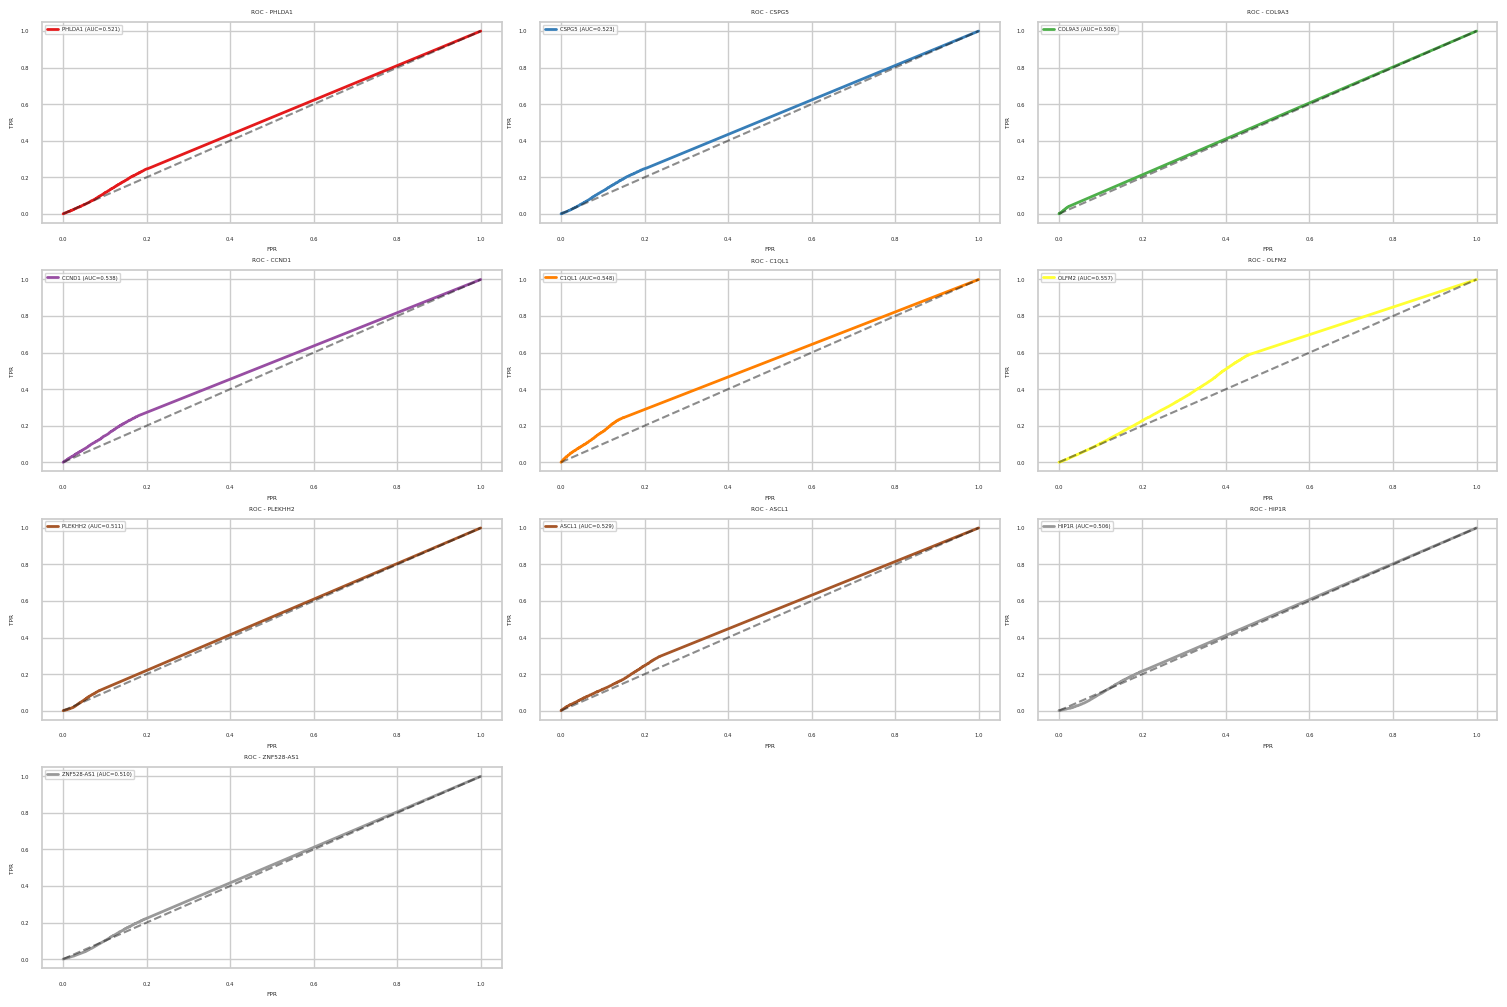

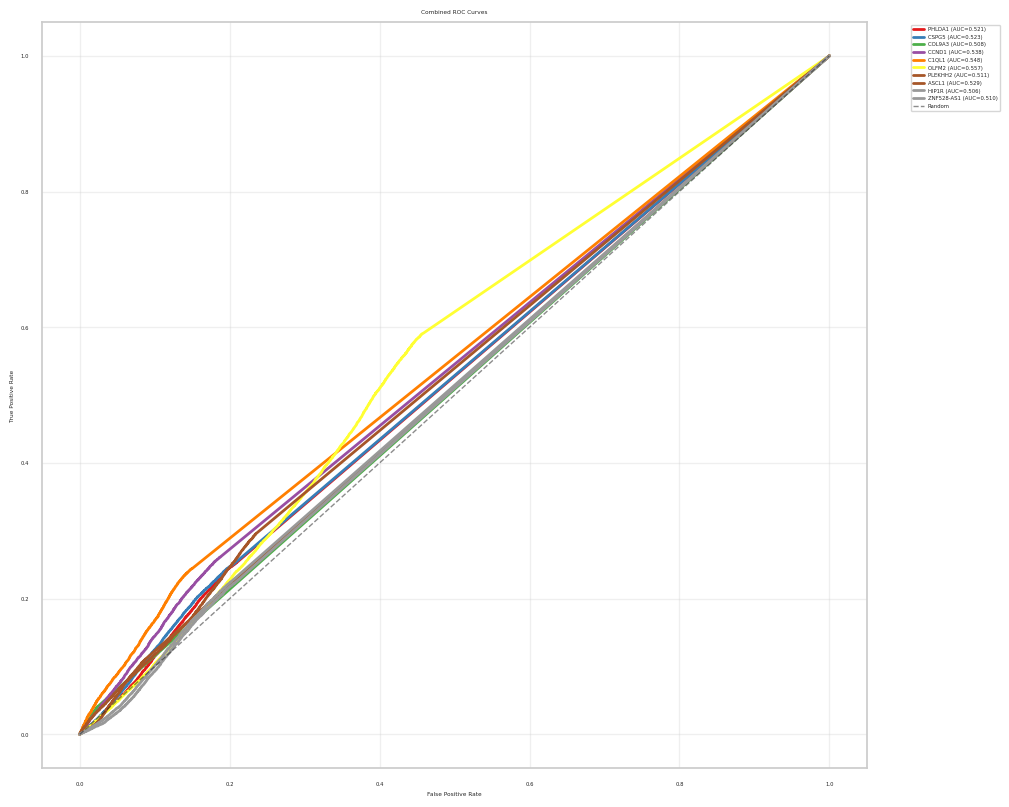

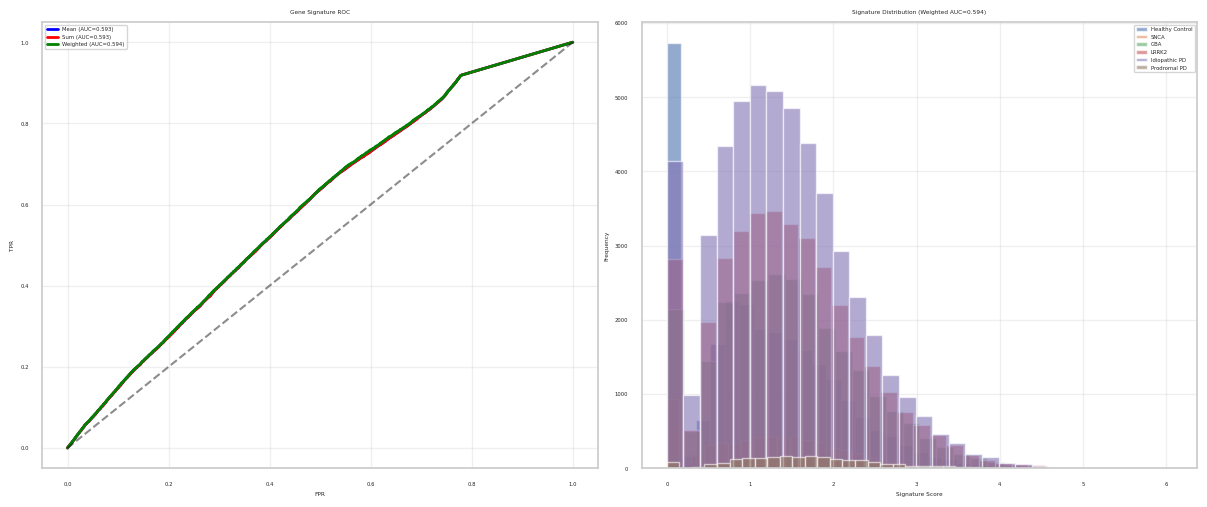

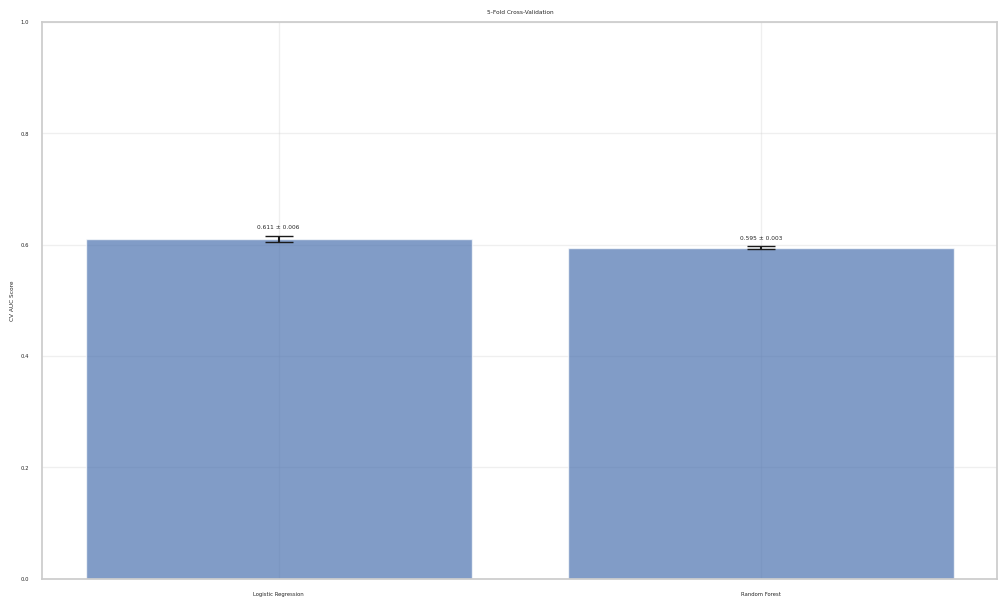

In [77]:
results = comprehensive_auc_analysis(
    adata=adata,
    target_genes=prodromal_genes,
    condition_key='Genotype',       # <- use the correct column name
    control_label='Healthy Control',
    cell_type_key='BroadCellType_harmonized',      # if you have this column
    cell_type_filter='dopamin|DA'   # optional filtering
)


In [78]:
individual_scores = results['individual_auc_scores']
cv_results = results['cv_results']

print("Code ready! Replace 'your_data.h5ad' with your actual file path and run the analysis.")
print("\nKey functions available:")
print("- comprehensive_auc_analysis(): Main analysis function")
print("- plot_individual_roc_curves(): Individual gene ROC plots")
print("- plot_combined_roc_curve(): Combined ROC plot")
print("- cross_validation_analysis(): Robustness testing")

Code ready! Replace 'your_data.h5ad' with your actual file path and run the analysis.

Key functions available:
- comprehensive_auc_analysis(): Main analysis function
- plot_individual_roc_curves(): Individual gene ROC plots
- plot_combined_roc_curve(): Combined ROC plot
- cross_validation_analysis(): Robustness testing


In [79]:
sig_auc, fpr, tpr, signature = calculate_gene_signature_auc(
    results['expr_df'],           # expression dataframe returned by the analysis
    results['available_genes'],   # genes found in your dataset
    control_label='Healthy Control',
    method='weighted'             # options: 'mean', 'sum', 'weighted'
)

print(f"Overall combined gene signature AUC = {sig_auc:.3f}")


Overall combined gene signature AUC = 0.594


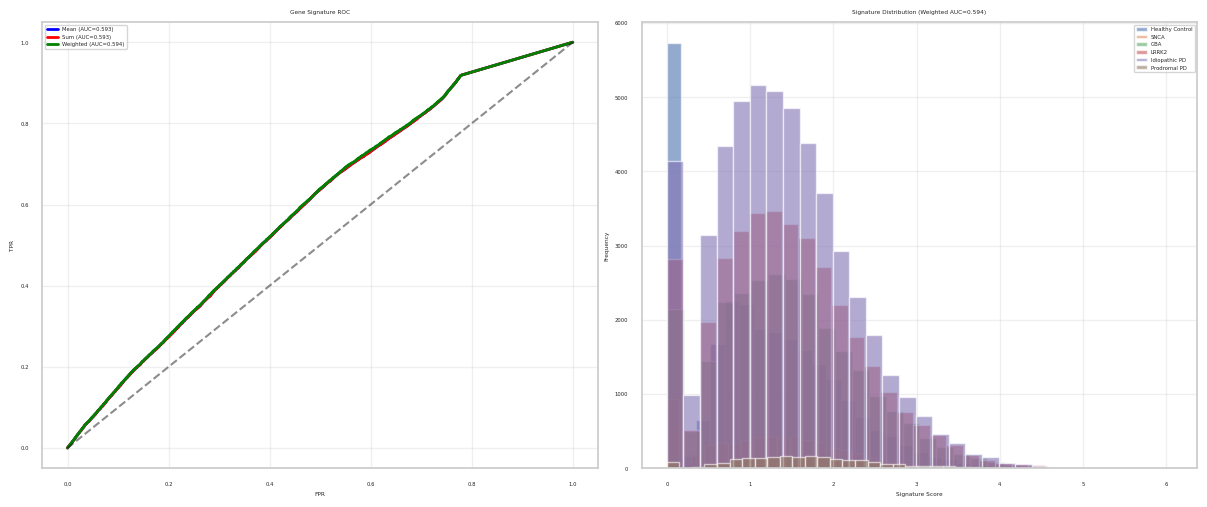

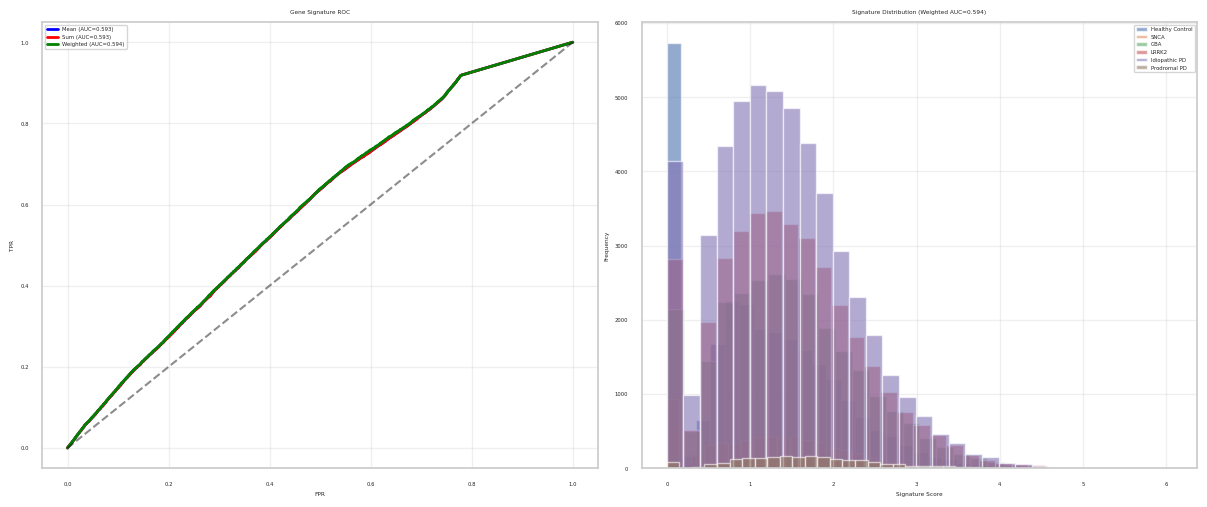

In [80]:
plot_signature_roc(
    results['expr_df'], 
    results['available_genes'], 
    control_label='Healthy Control'
)


In [81]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

def calculate_gene_signature_auc(expr_df, available_genes, control_label, positive_label=None, method='weighted'):
    """
    Compute AUC for a combined gene signature score.

    Parameters
    ----------
    expr_df : pd.DataFrame
        Expression dataframe with columns ['Condition', 'Cell', gene1, gene2, ...].
    available_genes : list
        Genes included in the analysis.
    control_label : str
        Label in expr_df['Condition'] for control samples.
    positive_label : str, optional
        Specific label to compare against control (e.g., 'Prodromal').
        If None, all non-control are treated as positive.
    method : str
        'mean', 'sum', or 'weighted' (weights = individual gene AUCs).

    Returns
    -------
    auc : float
        AUC of combined signature.
    fpr, tpr : arrays
        ROC curve data.
    signature_scores : np.ndarray
        Combined signature values.
    """

    # Subset to control + positive
    if positive_label is not None:
        df = expr_df[(expr_df['Condition'].isin([control_label, positive_label]))].copy()
        df['Binary'] = (df['Condition'] == positive_label).astype(int)
    else:
        df = expr_df.copy()
        df['Binary'] = (df['Condition'] != control_label).astype(int)

    # Compute signature
    if method == 'mean':
        signature = df[available_genes].mean(axis=1)
    elif method == 'sum':
        signature = df[available_genes].sum(axis=1)
    elif method == 'weighted':
        aucs = {}
        for g in available_genes:
            try:
                aucs[g] = roc_auc_score(df['Binary'], df[g])
            except Exception:
                aucs[g] = 0.5
        weights = np.array([aucs[g] for g in available_genes])
        signature = df[available_genes].dot(weights) / weights.sum()
    else:
        raise ValueError("method must be 'mean', 'sum', or 'weighted'")

    auc = roc_auc_score(df['Binary'], signature)
    fpr, tpr, _ = roc_curve(df['Binary'], signature)

    return auc, fpr, tpr, signature


In [82]:
sig_auc, fpr, tpr, signature = calculate_gene_signature_auc(
    results['expr_df'],
    results['available_genes'],
    control_label='Healthy Control',
    positive_label='Prodromal PD',   # <-- must match exactly
    method='weighted'
)

print(f"Overall combined gene signature AUC (Prodromal PD vs Healthy Control) = {sig_auc:.3f}")


Overall combined gene signature AUC (Prodromal PD vs Healthy Control) = 0.679


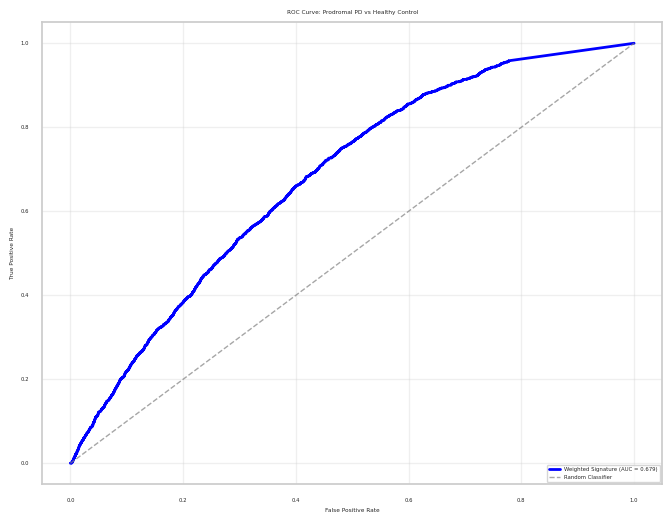

In [83]:
import matplotlib.pyplot as plt

# فرض: sig_auc, fpr, tpr, signature از قبل محاسبه شده

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Weighted Signature (AUC = {sig_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', alpha=0.7, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Prodromal PD vs Healthy Control')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
